# Imports and data

In [1]:




import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim
import random
from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModel

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 8)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device, random_word_mask, dict2sampleList
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment, DefinedAffine, HalfSwap
from facebook_hateful_memes_detector.preprocessing import NegativeSamplingDataset, ImageFolderDataset, ZipDatasets
from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBert import VilBertVisualBertModel
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
from facebook_hateful_memes_detector.utils import get_vgg_face_model, get_torchvision_classification_models, init_fc, my_collate
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)

scheduler_init_fn = get_cosine_schedule_with_warmup()
# Use mixup in SSL training, Use UDA maybe


In [2]:
def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.8, 0.1], char_level)
    word_level = {"fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.2,
                 "stopword_insert": 0.0, "word_join": 0.2, "word_cutout": 0.8, "gibberish_insert": 0.0}
    word_level = TextAugment([0.2, 0.7, 0.1], word_level)
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, 
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.75, 0.25], sentence_level)
    gibberish = {"gibberish_insert": 0.25, "punctuation_insert": 0.75,}
    gibberish = TextAugment([0.75, 0.25], gibberish)
    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        text = gibberish(text)
        return text
    return process

preprocess_text = get_preprocess_text()

augs_dict = dict(
    grayscale=transforms.Grayscale(num_output_channels=3),
    hflip=transforms.RandomHorizontalFlip(p=1.0),
    rc2=transforms.Compose(
        [transforms.Resize(480),
         transforms.CenterCrop(400)]),
    rotate=DefinedRotation(15),
    affine=DefinedAffine(0, scale=(0.6, 0.6)),
    translate1=DefinedAffine(0, translate=(0.25, 0.25)),
    swap=HalfSwap(),
)
im_transform = ImageAugment(count_proba=[0.5, 0.5],
                            augs_dict=augs_dict,
                            choice_probas="uniform")

torchvision_pre_image_transform = transforms.Compose([
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomPerspective(distortion_scale=0.25, p=0.2),
    transforms.ColorJitter(brightness=0.1,
                           contrast=0.1,
                           saturation=0.1,
                           hue=0.1),
    transforms.RandomChoice([
        transforms.RandomRotation(15),
        transforms.RandomAffine(
            0,
            translate=(0.25, 0.25),
            scale=(0.6, 1.4),
            shear=None,
        ),
        transforms.RandomResizedCrop(480, scale=(0.6, 1.0))  # Zoom in
    ]),
])

# data = get_datasets(
#     data_dir="../data/",
#     train_text_transform=preprocess_text,
#     train_image_transform=im_transform,
#     test_text_transform=None,
#     test_image_transform=None,
#     train_torchvision_image_transform=transforms.RandomErasing(p=0.5,
#                                                                scale=(0.05,
#                                                                       0.2),
#                                                                ratio=(0.3,
#                                                                       3.3),
#                                                                value=0,
#                                                                inplace=False),
#     test_torchvision_image_transform=None,
#     train_torchvision_pre_image_transform=torchvision_pre_image_transform,
#     test_torchvision_pre_image_transform=None,
#     cache_images=True,
#     use_images=True,
#     dev=False,
#     test_dev=True,
#     keep_original_text=False,
#     keep_original_image=False,
#     keep_processed_image=True,
#     keep_torchvision_image=True,
#     train_mixup_config=dict(proba=0.0)
# )

data = get_datasets(
    data_dir="../data/",
    train_text_transform=None,
    train_image_transform=None,
    test_text_transform=None,
    test_image_transform=None,
    train_torchvision_image_transform=None,
    test_torchvision_image_transform=None,
    train_torchvision_pre_image_transform=None,
    test_torchvision_pre_image_transform=None,
    cache_images=True,
    use_images=True,
    dev=False,
    test_dev=True,
    keep_original_text=False,
    keep_original_image=False,
    keep_processed_image=True,
    keep_torchvision_image=True,
    train_mixup_config=dict(proba=0.0)
)

df = pd.concat((data["train"].drop(columns=["label"]), data["dev"].drop(columns=["label"]), data["test"]))


In [3]:
dataset = convert_dataframe_to_dataset(df, data["metadata"], True)

and then i says to her no, i got your nose | Label =  0
Example Mixup 
 and then i says to her no, i got your nose wouldn't be the last time those people used the oven this way | Label =  0


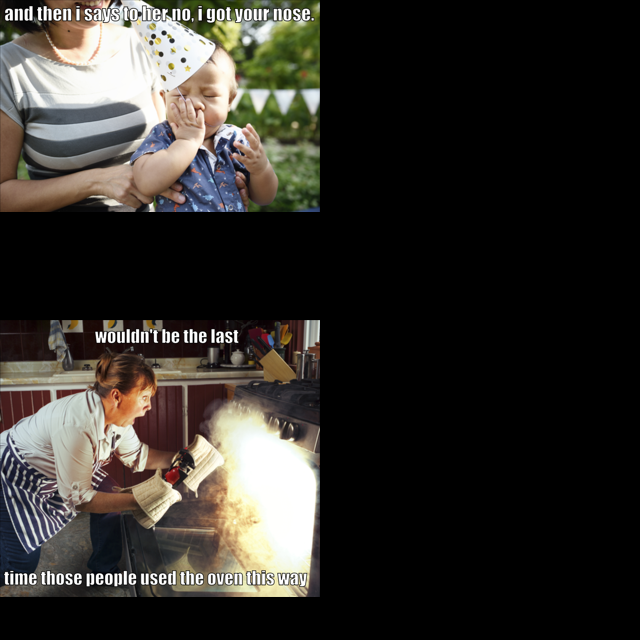

In [5]:
dataset.show_mixup(230) # 191

In [4]:
model_params = dict(
    model_name={"lxmert": dict(dropout=0.0, gaussian_noise=0.0)},
    num_classes=2,
    gaussian_noise=0.0,
    dropout=0.0,
    word_masking_proba=0.15,
    featurizer="pass",
    final_layer_builder=fb_1d_loss_builder,
    internal_dims=768,
    classifier_dims=768,
    n_tokens_in=96,
    n_tokens_out=96,
    n_layers=0,
    attention_drop_proba=0.0,
    loss="focal",
    dice_loss_coef=0.0,
    auc_loss_coef=0.0,
    bbox_swaps=1,
    bbox_copies=1,
    bbox_gaussian_noise=0.0,
    finetune=False)

model_class = VilBertVisualBertModel
model = model_class(**model_params)
model.to(get_device())


LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Load LXMERT pre-trained model from /home/ahemf/.pytorch_pretrained_bert/acfabf2c6d3708e226675d880fed09a14878ef2aee577eeefa8e27a6a22d5b3e.5392626539fa4619737ae314ee55e15de3097750e782865c604a83312ea77251

Weights in loaded but not in model:
answer_head.logit_fc.0.bias
answer_head.logit_fc.0.weight
answer_head.logit_fc.2.bias
answer_head.logit_fc.2.weight
answer_head.logit_fc.3.bias
answer_head.logit_fc.3.weight
cls.predictions.bias
cls.predictions.decoder.weight
cls.predictions.transform.LayerNorm.bias
cls.predictions.transform.LayerNorm.weight
cls.predictions.transform.dense.bias
cls.predictions.transform.dense.weight
cls.seq_relationship.bias
cls.seq_relationship.weight
obj_predict_head.decoder_dict.attr.bias
obj_predict_head.decoder_dict.attr.weight
obj_predict_head.decoder_dict.feat.bias
obj_predict_head.decoder_dict.feat.weight
obj_predict_head.decoder_dict.obj.bias
obj_predict_head.decoder_dict.obj.weight
obj_predict_head.tr

Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


N tokens Out =  132 Classifier Dims =  768 Matches embedding_dims:  True


VilBertVisualBertModel(
  (model_regularizers): ModuleDict(
    (lxmert): Sequential(
      (0): Dropout(p=0.0, inplace=False)
      (1): GaussianNoise()
    )
  )
  (model_heads): ModuleDict(
    (lxmert): LinearHead(
      (loss): FocalLoss()
      (classifier): Sequential(
        (0): Dropout(p=0.0, inplace=False)
        (1): Linear(in_features=768, out_features=2, bias=True)
      )
    )
  )
  (bbox_gaussian_noise): GaussianNoise()
  (lxmert): LXRTEncoder(
    (model): LXRTFeatureExtraction(
      (bert): LXRTModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768, padding_idx=0)
          (token_type_embeddings): Embedding(2, 768, padding_idx=0)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): LXRTEncoder(
          (visn_fc): VisualFeatEncoder(
            (visn_fc)

# Unimodal

- Do multiple iterations of augsim and nsp with less epochs, start with nsp for unimodal tasks.
- Use placeholder Images. torch.rand()?
- Use placeholder text `<mask>` token


## MLM

In [5]:


adam = torch.optim.Adam
adam_params = params = dict(lr=1e-4, weight_decay=1e-2)
optimizer = adam
optimizer_params = adam_params


from facebook_hateful_memes_detector.utils import MLMPretraining
mlm_model = MLMPretraining(model, model.text_processor._tokenizer, 768, "relu", 96)
mlm_model = mlm_model.to(get_device())


LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Load LXMERT pre-trained model from /home/ahemf/.pytorch_pretrained_bert/acfabf2c6d3708e226675d880fed09a14878ef2aee577eeefa8e27a6a22d5b3e.5392626539fa4619737ae314ee55e15de3097750e782865c604a83312ea77251

Weights in loaded but not in model:
answer_head.logit_fc.0.bias
answer_head.logit_fc.0.weight
answer_head.logit_fc.2.bias
answer_head.logit_fc.2.weight
answer_head.logit_fc.3.bias
answer_head.logit_fc.3.weight
cls.predictions.bias
cls.predictions.decoder.weight
cls.predictions.transform.LayerNorm.bias
cls.predictions.transform.LayerNorm.weight
cls.predictions.transform.dense.bias
cls.predictions.transform.dense.weight
cls.seq_relationship.bias
cls.seq_relationship.weight
obj_predict_head.decoder_dict.attr.bias
obj_predict_head.decoder_dict.attr.weight
obj_predict_head.decoder_dict.feat.bias
obj_predict_head.decoder_dict.feat.weight
obj_predict_head.decoder_dict.obj.bias
obj_predict_head.decoder_dict.obj.weight
obj_predict_head.tr

Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


N tokens Out =  132 Classifier Dims =  768 Matches embedding_dims:  True


Autocast =  False Epochs =  5 Divisor = 1 Examples = 10000 Batch Size =  128
Training Samples =  10000 Weighted Sampling =  False Num Batches =  79 Accumulation steps =  2
[WARN]: Number of training batches not divisible by accumulation steps, some training batches will be wasted due to this.


Modifications for VG in RPN (modeling/proposal_generator/rpn.py):
	Use hidden dim 512 instead fo the same dim as Res4 (1024).

Modifications for VG in RoI heads (modeling/roi_heads/fast_rcnn.py))
	Embedding: 1601 --> 256	Linear: 2304 --> 512	Linear: 512 --> 401

LXMERTFeatureExtractor : Loaded Model...

Epoch =  1 Loss = 7.691794 LR = 0.00006695



Epoch =  2 Loss = 3.556470 LR = 0.00009494



Epoch =  3 Loss = 2.717949 LR = 0.00006097



Epoch =  4 Loss = 2.451082 LR = 0.00001876



Epoch =  5 Loss = 2.388329 LR = 0.00000000



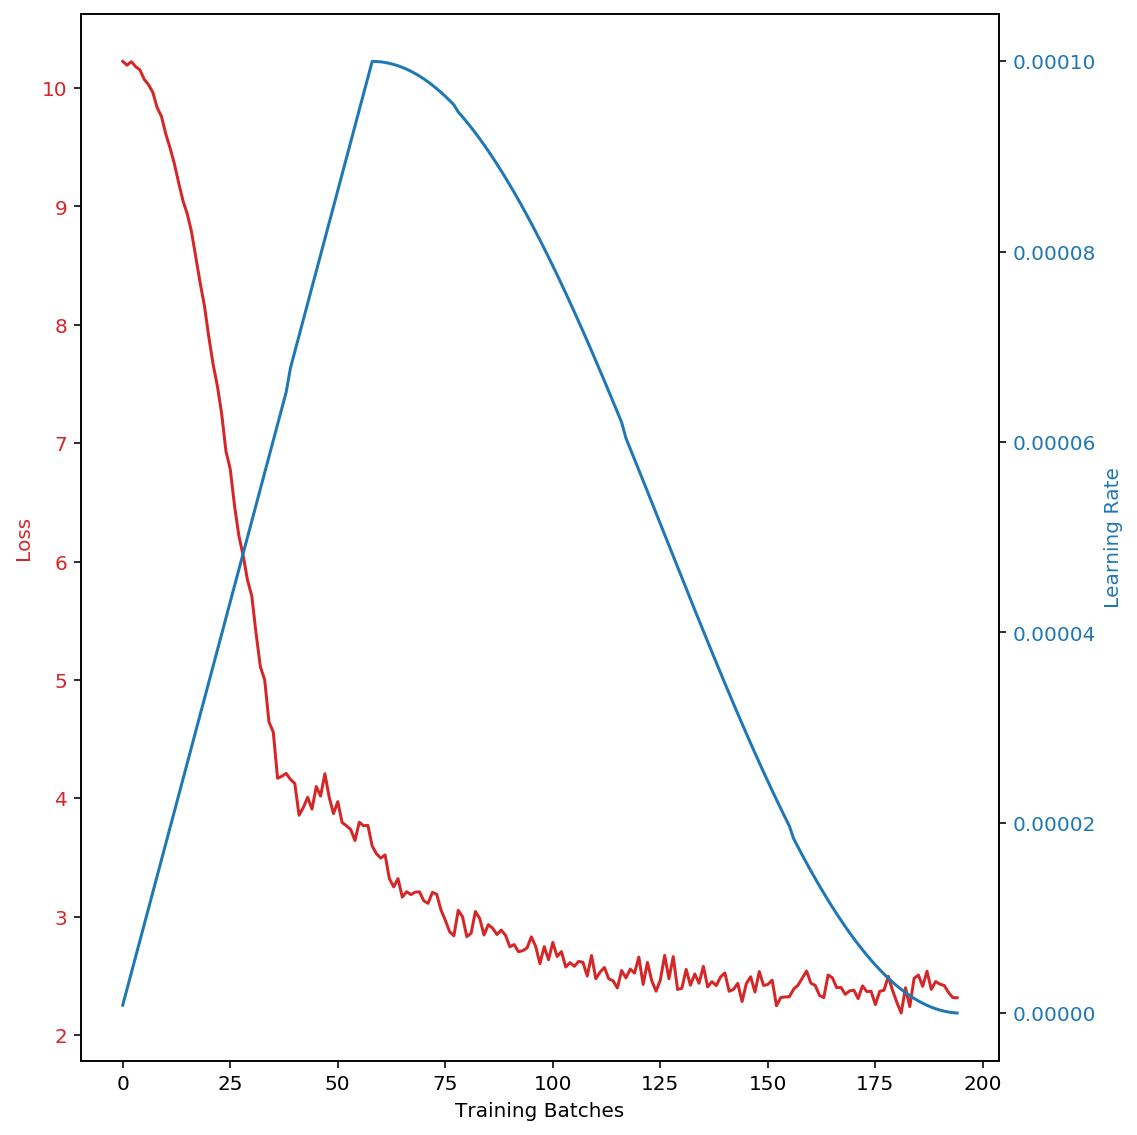

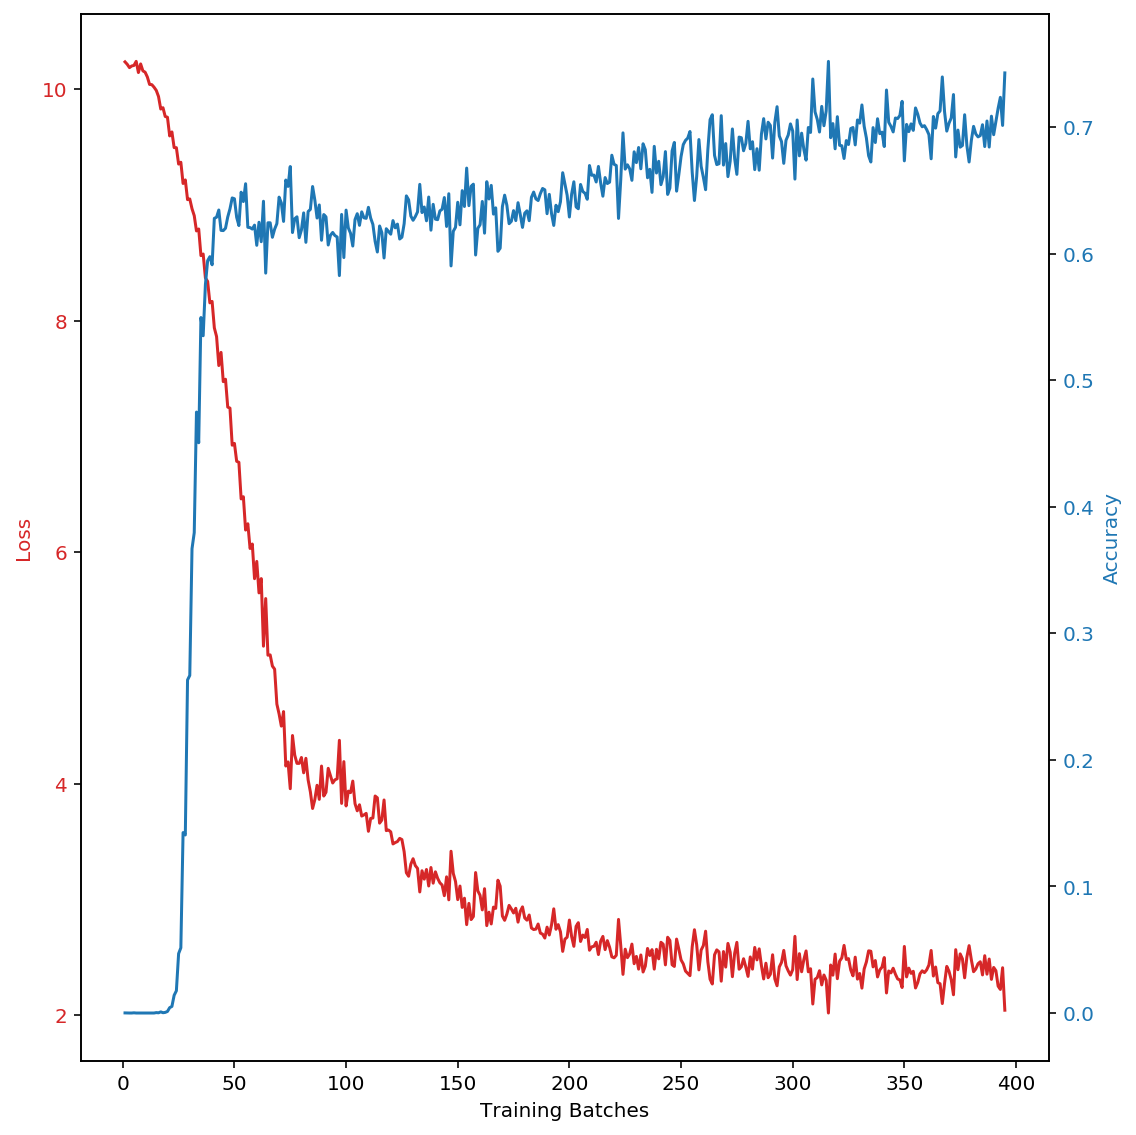


MLM Accuracy = 0.7048


0.7048125

In [5]:

lr_strategy = {
    "model": {
        "finetune": False,
    },
    "mlm": {
        "finetune": True
    }
}
epochs = 5
batch_size = 128
optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)

_ = group_wise_finetune(mlm_model, lr_strategy)
params_conf, _ = group_wise_lr(mlm_model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)
train_losses, learning_rates = train(mlm_model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=2, plot=True,
                                     sampling_policy=None, class_weights=None)



mlm_model.plot_loss_acc_hist()
mlm_model.test_accuracy(batch_size, dataset)




In [14]:
torch.save(mlm_model.state_dict(), "lxmert-mlm-init.pth")
# mlm_model.load_state_dict(torch.load("lxmert-mlm-init.pth"))


Autocast =  False Epochs =  2 Divisor = 1 Examples = 10000 Batch Size =  48
Training Samples =  10000 Weighted Sampling =  False Num Batches =  209 Accumulation steps =  4
[WARN]: Number of training batches not divisible by accumulation steps, some training batches will be wasted due to this.



Epoch =  1 Loss = 1.097376 LR = 0.00001621



Epoch =  2 Loss = 0.995201 LR = 0.00000000



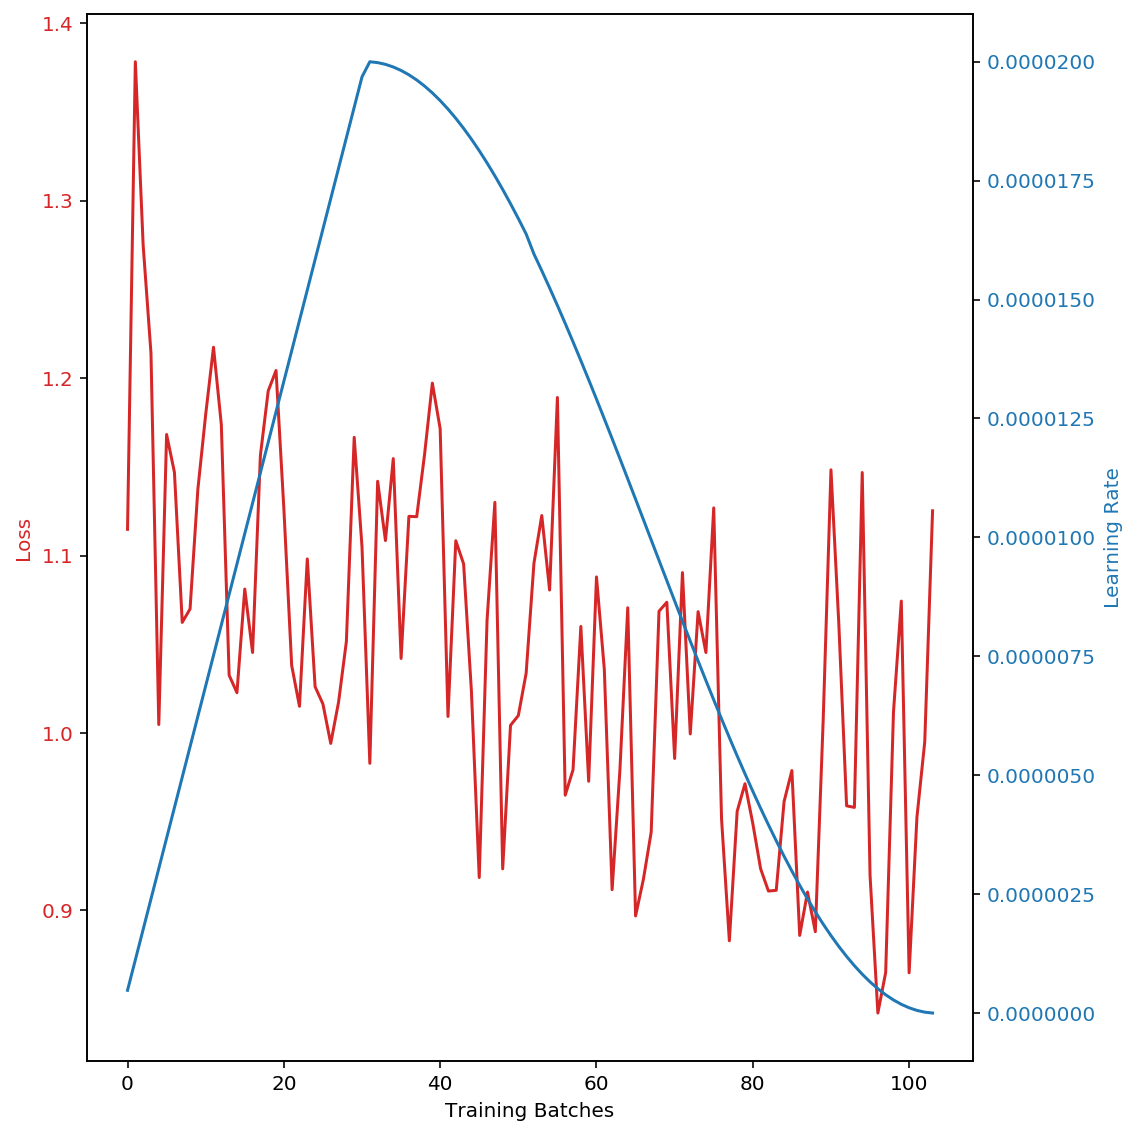

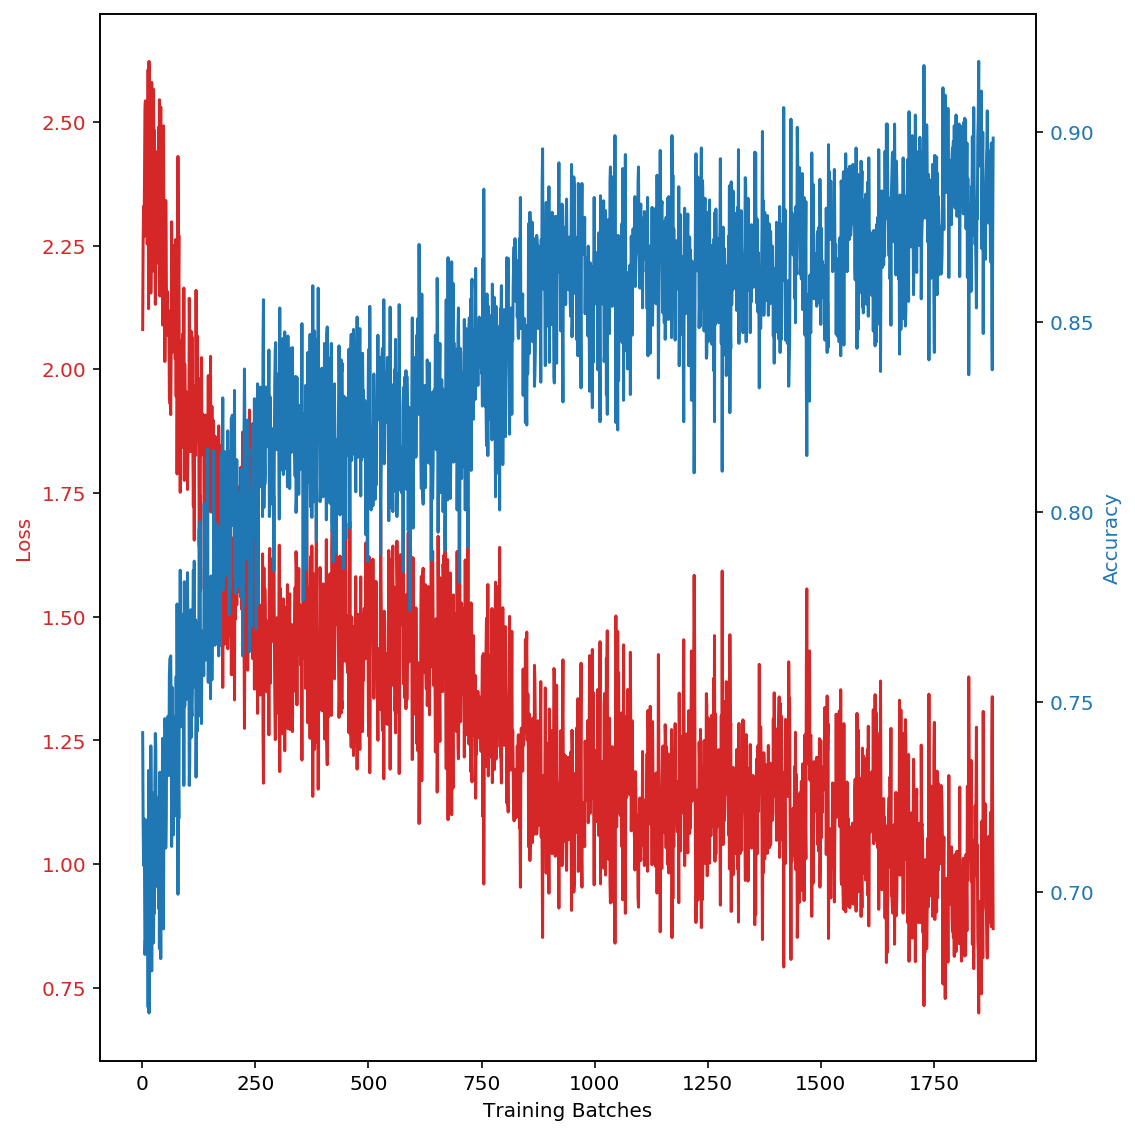


MLM Accuracy = 0.8836


In [13]:

epochs = 5
batch_size = 48
optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-4)

lr_strategy = {
    "model": {
        "finetune": True,
        "lr": optimizer_params["lr"]/5
    },
    "mlm": {
        "finetune": True
    }
}

_ = group_wise_finetune(mlm_model, lr_strategy)
params_conf, _ = group_wise_lr(mlm_model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)
train_losses, learning_rates = train(mlm_model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=4, plot=True,
                                     sampling_policy=None, class_weights=None)



mlm_model.plot_loss_acc_hist()
acc = mlm_model.test_accuracy(batch_size, dataset)


In [12]:
acc = mlm_model.test_accuracy(batch_size, dataset)


MLM Accuracy = 0.8644


In [ ]:
torch.save(mlm_model.model.state_dict(), "lxmert-mlm.pth")


# AugSim
- Combine both unimodal and bimodal augsim using `random.random`
- Take hints from SimCLR


In [5]:
# model.load_state_dict(torch.load("lxmert-mlm.pth"))
set_global("cache_allow_writes", False)


In [5]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_class = adamw
optimizer_params = adamw_params


def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.8, 0.1], char_level)
    word_level = {"fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.2,
                 "stopword_insert": 0.0, "word_join": 0.2, "word_cutout": 0.8, "gibberish_insert": 0.0}
    word_level = TextAugment([0.2, 0.7, 0.1], word_level)
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, 
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.75, 0.25], sentence_level)
    gibberish = {"gibberish_insert": 0.25, "punctuation_insert": 0.75,}
    gibberish = TextAugment([0.75, 0.25], gibberish)
    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        text = gibberish(text)
        return text
    return process

preprocess_text = get_preprocess_text()

vectorized_text_processor = np.vectorize(preprocess_text)

preprocess = transforms.Compose([
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomPerspective(distortion_scale=0.25, p=0.2),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomChoice([
        transforms.RandomRotation(30),
        DefinedRotation(90),
        HalfSwap(),
        QuadrantCut(),
        transforms.RandomAffine(
            0,
            translate=(0.25, 0.25),
            scale=(0.6, 1.4),
            shear=None,
        ),
        transforms.RandomChoice([
            transforms.Compose([transforms.Resize(256), transforms.RandomCrop(224)]),
            transforms.Compose([transforms.Resize(480), transforms.RandomCrop(400)]),
            transforms.Compose([transforms.Resize(384), transforms.RandomCrop(320)]),
        ]), 
        transforms.RandomResizedCrop(480, scale=(0.6, 1.0)) # Zoom in
    ]), 
])

def vectorized_image_processor(images):
    return [preprocess(i) for i in images]

preprocess_torchvision_image = transforms.RandomErasing(p=0.5, scale=(0.05, 0.25))

def augment_method(sampleList):
    sampleList = dict2sampleList(sampleList, device=get_device())
    img = sampleList.torchvision_image
    for idx, im in enumerate(img):
        img[idx] = preprocess_torchvision_image(im)
    sampleList.torchvision_image = img
    sampleList.image = vectorized_image_processor(sampleList.image)
    sampleList.text = vectorized_text_processor(sampleList.text)
    sampleList.mixup = [True] * len(sampleList.text)
    sampleList = sampleList.to(get_device())
    return sampleList
        


In [ ]:
epochs = 2
batch_size = 64
lr_strategy = {
    "lxmert": {
        "model": {
            "bert": {
                "encoder": {
                    "finetune": True,
                },
                "pooler": {
                    "finetune": True,
                }
            },
            "finetune": False,
        }
    }
}

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optim = optimizer_class(params_conf, **optimizer_params)

_ = train_for_augment_similarity(model,
                                 optim,
                                 scheduler_init_fn,
                                 batch_size,
                                 epochs,
                                 dataset,
                                 augment_method=augment_method,
                                 model_call_back=None,
                                 collate_fn=my_collate,
                                 accumulation_steps=2,
                                 plot=True)


Autocast =  True Epochs =  2 Examples = 10000 Batch Size =  64
Training Samples =  10000 Weighted Sampling =  False Num Batches =  157 Accumulation steps =  2
[WARN]: Number of training batches not divisible by accumulation steps, some training batches will be wasted due to this.


Modifications for VG in RPN (modeling/proposal_generator/rpn.py):
	Use hidden dim 512 instead fo the same dim as Res4 (1024).

Modifications for VG in RoI heads (modeling/roi_heads/fast_rcnn.py))
	Embedding: 1601 --> 256	Linear: 2304 --> 512	Linear: 512 --> 401

LXMERTFeatureExtractor : Loaded Model...


# SimCLR style or Differentiator
- Combine Unimodal and Bimodal with probability
- In unimodal differentiator we only change either text or image

# Image Text Match

## Text-Text-Image
- Find right text corresponding to Image


## 4 Image Collage - Text match
- Use mixup to mix 4 images and text. Keep text of only 1 sample. 
- Next model has to identify which image matches the text.
